In [1]:
from pathlib import Path
from typing import Union, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from dlsvm.models import DnnSvm
from dlsvm.tools import build_model, label_2_onehot

In [2]:
out = Path('./0521_digits_cnn_softmax')
if not out.exists():
    out.mkdir(parents=True)

In [3]:
sns.set()

### Load dataset

In [4]:
digits = datasets.load_digits()

In [5]:
digits = datasets.load_digits()
X = digits.data.astype(np.float32).reshape(-1, 8, 8, 1)
y = digits.target.astype(np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_, X_train_val, y_train_, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
y_train_ = label_2_onehot(y_train_)
y_train_val = label_2_onehot(y_train_val)

### Build model

In [8]:
n_class=len(digits.target_names)
n_h=64
activation='relu'
kernel_initializer='he_uniform'
output_function = 'softmax'

In [9]:
cnn = tfk.Sequential(
    [
        tfk.layers.Conv2D(
            input_shape=(8, 8, 1),
            filters=16,
            kernel_size=(3, 3),
            padding='same',
        ),
        tfk.layers.Flatten(),
        tfk.layers.Dense(
            n_h,
            kernel_initializer=kernel_initializer,
            activation=activation
        ),
        tfk.layers.Dense(
            n_class,
            kernel_initializer=kernel_initializer,
            activation=output_function
        )
    ]
)

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          160       
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 66,410
Trainable params: 66,410
Non-trainable params: 0
_________________________________________________________________


In [11]:
dlsvm = build_model(
    n_class=n_class,
    model=cnn,
    penalty=1.,
    softmax=True
)

In [12]:
batch_size = 64
epochs = 50
learning_rate = 1e-3
patience = 5
loss = 'categorical_crossentropy'

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dlsvm.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [14]:
es_cb = tfk.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, mode='auto'
)
tb_cb = tfk.callbacks.TensorBoard(log_dir=str(out))
cl_cb = tfk.callbacks.CSVLogger(
    str(out.joinpath('train.log.csv')), separator=',', append=False
)
cp_cb = tfk.callbacks.ModelCheckpoint(
    str(out.joinpath('model.weights.h5')), monitor='val_acc', verbose=0,
    save_best_only=True, save_weights_only=False, mode='auto', period=1
)

### Train model

In [15]:
history = dlsvm.fit(
    *(X_train_, y_train_),
    validation_data=(X_train_val, y_train_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tb_cb, cl_cb, cp_cb]
)

Train on 1149 samples, validate on 288 samples
Epoch 1/50
1149/1149 [==============================] - 2s 1ms/sample - loss: 2.0777 - acc: 0.5013 - val_loss: 0.6490 - val_acc: 0.7882
Epoch 2/50
1149/1149 [==============================] - 0s 226us/sample - loss: 0.3283 - acc: 0.8973 - val_loss: 0.3016 - val_acc: 0.8958
Epoch 3/50
1149/1149 [==============================] - 0s 236us/sample - loss: 0.1659 - acc: 0.9539 - val_loss: 0.2102 - val_acc: 0.9410
Epoch 4/50
1149/1149 [==============================] - 0s 213us/sample - loss: 0.1216 - acc: 0.9669 - val_loss: 0.1776 - val_acc: 0.9410
Epoch 5/50
1149/1149 [==============================] - 0s 243us/sample - loss: 0.0896 - acc: 0.9756 - val_loss: 0.1293 - val_acc: 0.9618
Epoch 6/50
1149/1149 [==============================] - 0s 182us/sample - loss: 0.0686 - acc: 0.9861 - val_loss: 0.1343 - val_acc: 0.9514
Epoch 7/50
1149/1149 [==============================] - 0s 193us/sample - loss: 0.0564 - acc: 0.9904 - val_loss: 0.1178 - val_a

In [16]:
df_result = pd.DataFrame(history.history)

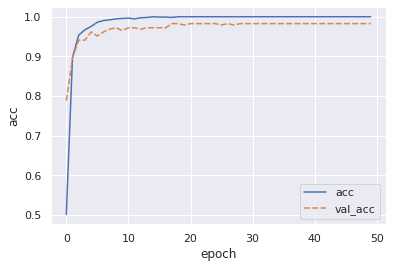

In [17]:
sns.lineplot(data=df_result[['acc', 'val_acc']])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(out.joinpath('acc_logs.pdf'))

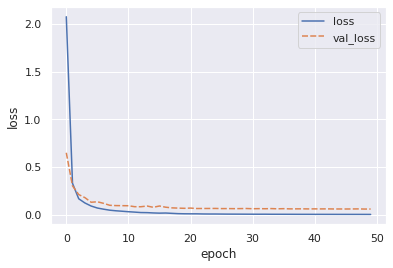

In [18]:
sns.lineplot(data=df_result[['loss', 'val_loss']])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(out.joinpath('loss_logs.pdf'))

In [19]:
dlsvm.load_weights(str(out.joinpath('model.weights.h5')))

In [20]:
dlsvm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          160       
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 66,410
Trainable params: 66,410
Non-trainable params: 0
_________________________________________________________________


### Performance of model

In [21]:
df_train = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_train), axis=-1), y_true=y_train, output_dict=True)
)
print('Train perfomance of model')
print(df_train)
df_train.to_csv(out.joinpath('train-performance.csv'))

Train perfomance of model
             0.0         1.0    2.0         3.0    4.0         5.0    6.0  \
f1-score     1.0    0.996764    1.0    0.989967    1.0    0.996283    1.0   
precision    1.0    0.993548    1.0    0.986667    1.0    1.000000    1.0   
recall       1.0    1.000000    1.0    0.993289    1.0    0.992593    1.0   
support    145.0  154.000000  144.0  149.000000  135.0  135.000000  146.0   

                  7.0         8.0         9.0    micro avg    macro avg  \
f1-score     0.993103    0.993056    0.996416     0.996521     0.996559   
precision    0.993103    0.993056    1.000000     0.996521     0.996637   
recall       0.993103    0.993056    0.992857     0.996521     0.996490   
support    145.000000  144.000000  140.000000  1437.000000  1437.000000   

           weighted avg  
f1-score       0.996523  
precision      0.996534  
recall         0.996521  
support     1437.000000  


In [22]:
df_test = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_test), axis=-1), y_true=y_test, output_dict=True)
)
print('Test perfomance of model')
print(df_test)
df_test.to_csv(out.joinpath('test-performance.csv'))

Test perfomance of model
            0.0   1.0        2.0        3.0   4.0        5.0        6.0  \
f1-score    1.0   1.0   0.984615   0.956522   1.0   0.958333   0.971429   
precision   1.0   1.0   1.000000   0.942857   1.0   0.938776   0.971429   
recall      1.0   1.0   0.969697   0.970588   1.0   0.978723   0.971429   
support    33.0  28.0  33.000000  34.000000  46.0  47.000000  35.000000   

                 7.0        8.0        9.0   micro avg   macro avg  \
f1-score    0.985075   0.966667   0.962025    0.977778    0.978467   
precision   1.000000   0.966667   0.974359    0.977778    0.979409   
recall      0.970588   0.966667   0.950000    0.977778    0.977769   
support    34.000000  30.000000  40.000000  360.000000  360.000000   

           weighted avg  
f1-score       0.977859  
precision      0.978205  
recall         0.977778  
support      360.000000  


In [23]:
np.argmax(dlsvm.predict(X_train), axis=-1)

array([6, 0, 0, ..., 2, 7, 1])

In [24]:
np.argmax(dlsvm.predict(X_test), axis=-1)

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 3, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 3, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 8, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 5, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,